In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
np.random.seed(0)

In [2]:
def change_dates(df):
    #changes fecha_inicio_sintomas according to new criteria
    filt_df2 = (df.fecha_inicio_sintomas.isnull()) #filter fecha_inicio_sintomas = inexistant
    n_size = (df[filt_df2]).shape[0]
    df["fecha_inicio_sintomas"] = df["fecha_inicio_sintomas"].fillna(0)
    df["fecha_inicio_sintomas"] = df["fecha_inicio_sintomas"].astype('int')
    df["fecha_apertura"] = df["fecha_apertura"].astype('int')
    b = np.array(df["fecha_apertura"].values)
    a = np.array(df["fecha_inicio_sintomas"].values)
    a[filt_df2.values] = b[filt_df2.values] - np.random.randint(0,9,a[filt_df2.values].shape)
    filt_a = np.where(a<0)
    a[filt_a] = 0
    df = df.drop(["fecha_inicio_sintomas"],axis=1)
    df["fecha_inicio_sintomas"] = a
    return df

## Carga de datos, sacamos las series temporal

In [3]:
direccion = '12en20.csv'
columnas = ['residencia_provincia_nombre','residencia_departamento_nombre','fecha_inicio_sintomas',
            'fecha_apertura','clasificacion_resumen']
data = pd.read_csv(direccion,sep=",",quotechar='"', usecols=columnas,
                   parse_dates=["fecha_inicio_sintomas","fecha_apertura"],na_values=['']) 

In [4]:
data = data[data["clasificacion_resumen"] == "Confirmado"] #filter confirmed cases
df = pd.DataFrame(data) 

In [5]:
df = df.drop(['clasificacion_resumen'], axis=1) #drop clasificacion_resumen bc previous filter of confirmed cases

In [6]:
filt_df1 = (df.fecha_inicio_sintomas.notnull()) #filter fecha_inicio_sintomas = inexistant
inicio_epidemia = (df.loc[filt_df1,"fecha_inicio_sintomas"]).min() #first symptoms of a person registered
ultima_actualizacion_sintomas = (df.loc[filt_df1,"fecha_inicio_sintomas"]).max() #last day symptoms of a person registered
ultima_actualizacion_apertura = (df["fecha_apertura"]).max()
df["fecha_inicio_sintomas"] -= inicio_epidemia #correcting by inicio_epidemia 
df["fecha_apertura"] -= inicio_epidemia #correcting by inicio_epidemia
df.fecha_inicio_sintomas = df.fecha_inicio_sintomas.dt.days #change to int, ditch days 
df.fecha_apertura = df.fecha_apertura.dt.days #change to int, ditch days
print("primer sintoma de persona confirmada: ",inicio_epidemia)
print("ultimo sintoma de persona confirmada: ",ultima_actualizacion_sintomas)
print("ultima apertura de persona confirmada: ",ultima_actualizacion_apertura)

primer sintoma de persona confirmada:  2020-01-01 00:00:00
ultimo sintoma de persona confirmada:  2021-01-11 00:00:00
ultima apertura de persona confirmada:  2021-01-11 00:00:00


In [7]:
df = change_dates(df) # we have replaced all bad or undefined dates

In [8]:
df = df[["residencia_departamento_nombre","fecha_inicio_sintomas"]]
df2 = df.groupby(["residencia_departamento_nombre","fecha_inicio_sintomas"]).size().reset_index() 
df2 = df2.rename(columns={0:'casos'})
df3 = df2.sort_values(["residencia_departamento_nombre","fecha_inicio_sintomas"],ascending=[True,True])

In [9]:
#let's list all the provinces that have cases (all rn tbh, but just to use pandas stuff)
#we'll get those times series then, with pd grouping
provincias = pd.Series(df3["residencia_departamento_nombre"].unique())
#print: we get provinces + the sin especificar / unespecified thing
print(provincias)

0      12 de Octubre
1         1º de Mayo
2         2 de Abril
3         25 de Mayo
4         9 de Julio
           ...      
442           Zapala
443            Zonda
444           Zárate
445        Ñorquincó
446          Ñorquín
Length: 447, dtype: object


In [10]:
rows = provincias.shape[0]
cols = df2["fecha_inicio_sintomas"].max()
time_series = np.zeros(shape=(rows,cols+1))
time_series_ac = np.zeros(shape=(rows,cols+1))

In [11]:
time_series[0,376]

0.0

In [12]:
j = 0
for i in provincias:
  df_tmp = df3[df3["residencia_departamento_nombre"]==i]
  tmp_dates = np.array(df_tmp["fecha_inicio_sintomas"].values)
  tmp_cases = np.array(df_tmp["casos"].values)
  time_series[j,tmp_dates]= tmp_cases
  j = j + 1

In [13]:
for i in range(rows):
  for j in range(13,cols):
    time_series_ac[i,j] = np.sum(time_series[i,j-13:j+1])

## Primero, aca vamos a calcular la correlacion de Pearson y chequear que de todo bien

Esto funciona aca y esta todo tranquilo, no hay problema!

In [14]:
#no existe en cupy, la hago yo a esta funcion 
def pearsonr(a,b):
  m_a = np.mean(a)
  m_b = np.mean(b)
  r_a = a - m_a
  r_b = b - m_b
  r_a_2 = np.sum((r_a)**2) 
  r_b_2 = np.sum((r_b)**2)
  r = np.sum((r_a*r_b)/np.sqrt(r_a_2*r_b_2))
  return r

In [15]:
#por ejemplo, correlaciones para caba y baires
caba = time_series_ac[1,:-10]
baires = time_series_ac[0,:-10]
pearsonr(caba,baires)

0.3789977770743418

In [16]:
#ahora, tratemos de hacer lo mismo para baires y el resto del país
baires = time_series_ac[0,:-10]
i = 1
provs = provincias
print('Coeficientes de Pearson')
while i < rows:
  prov_tmp = time_series_ac[i,:-10]
  r = pearsonr(baires,prov_tmp)
  print('Pearson entre '+provs[i]+' y Baires: ',np.around(r,3))
  i += 1

Coeficientes de Pearson
Pearson entre 1º de Mayo y Baires:  0.379
Pearson entre 2 de Abril y Baires:  0.72
Pearson entre 25 de Mayo y Baires:  0.624
Pearson entre 9 de Julio y Baires:  0.921
Pearson entre Adolfo Alsina y Baires:  0.637
Pearson entre Adolfo Gonzales Chaves y Baires:  0.731
Pearson entre Aguirre y Baires:  0.465
Pearson entre Albardón y Baires:  0.807
Pearson entre Alberdi y Baires:  0.166
Pearson entre Alberti y Baires:  0.828
Pearson entre Almirante Brown y Baires:  0.142
Pearson entre Aluminé y Baires:  0.871
Pearson entre Ambato y Baires:  0.435
Pearson entre Ancasti y Baires:  0.32
Pearson entre Andalgalá y Baires:  0.513
Pearson entre Angaco y Baires:  0.78
Pearson entre Anta y Baires:  0.622
Pearson entre Antofagasta de la Sierra y Baires:  0.08
Pearson entre Antártida Argentina y Baires:  0.363
Pearson entre Apóstoles y Baires:  0.681
Pearson entre Arauco y Baires:  0.285
Pearson entre Arrecifes y Baires:  0.442
Pearson entre Atamisqui y Baires:  0.418
Pearson en

Pearson entre Tandil y Baires:  0.519
Pearson entre Tapalqué y Baires:  0.288
Pearson entre Tapenagá y Baires:  0.076
Pearson entre Tehuelches y Baires:  0.594
Pearson entre Telsen y Baires:  0.563
Pearson entre Tercero Arriba y Baires:  0.289
Pearson entre Tigre y Baires:  0.183
Pearson entre Tilcara y Baires:  0.084
Pearson entre Tinogasta y Baires:  0.463
Pearson entre Toay y Baires:  0.742
Pearson entre Tordillo y Baires:  0.113
Pearson entre Tornquist y Baires:  0.324
Pearson entre Totoral y Baires:  0.583
Pearson entre Trancas y Baires:  0.678
Pearson entre Trenel y Baires:  0.628
Pearson entre Trenque Lauquen y Baires:  0.859
Pearson entre Tres Arroyos y Baires:  0.661
Pearson entre Tres Lomas y Baires:  0.519
Pearson entre Tres de Febrero y Baires:  0.078
Pearson entre Tulumba y Baires:  0.293
Pearson entre Tumbaya y Baires:  0.185
Pearson entre Tunuyán y Baires:  0.321
Pearson entre Tupungato y Baires:  0.265
Pearson entre Ullúm y Baires:  0.833
Pearson entre Unión y Baires:  

## Pruebo aca usar el correlate de Cupy, con lag y todo, verificamos que funciona okay. 

In [17]:
baires = time_series_ac[0,:-10]
caba = time_series_ac[1,:-10]

In [18]:
npts = baires.shape[0]
lags = np.arange(-npts + 1, npts)

In [19]:
ccov = np.correlate(baires - baires.mean(), caba - caba.mean(), mode='full')
ccor = ccov / (npts * baires.std() * caba.std())

max correlation is 0.604279
max correlation is at lag 32


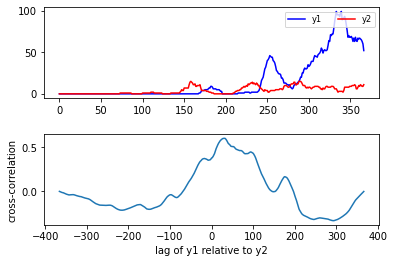

In [20]:
fig, axs = plt.subplots(nrows=2)
fig.subplots_adjust(hspace=0.4)
ax = axs[0]
ax.plot(baires, 'b', label='y1')
ax.plot(caba, 'r', label='y2')
ax.legend(loc='upper right', fontsize='small', ncol=2)

ax = axs[1]
ax.plot(lags, ccor)
ax.set_ylabel('cross-correlation')
ax.set_xlabel('lag of y1 relative to y2')

maxlag = lags[np.argmax(ccor)]
print("max correlation is %f" % np.max(ccor))
print("max correlation is at lag %d" % maxlag)

# Ahora, lo hacemos en serio, tipo todas las provincias contra todas las provincias, y guardamos los resultados

In [21]:
localidades_lagmax = np.zeros(shape=(rows,rows))
localidades_corrmax = np.zeros(shape=(rows,rows))
npts = cols
lags = np.arange(-npts + 1, npts)
i = 0
while i < rows:
    j = 0
    prov_tmp_1 = time_series_ac[i,:-10]
    while j < rows:
        prov_tmp_2 = time_series_ac[j,:-10]
        ccov = np.correlate(prov_tmp_1  - prov_tmp_1 .mean(), prov_tmp_2 - prov_tmp_2.mean(), mode='full')
        ccor = ccov / (npts * prov_tmp_1 .std() * prov_tmp_2.std())
        localidades_lagmax[i,j] = lags[np.argmax(ccor)]
        localidades_corrmax[i,j] = np.max(ccor)
        j = j + 1
    i = i +1

In [22]:
localidades_lagmax

array([[ -9.,  23.,   0., ...,  56.,  45., -36.],
       [-41.,  -9., -44., ...,  -9.,  -7., -84.],
       [-18.,  26.,  -9., ...,  57.,  29., -50.],
       ...,
       [-74.,  -9., -75., ...,  -9., -21., -81.],
       [-63., -11., -47., ...,   3.,  -9., -85.],
       [ 18.,  66.,  32., ...,  63.,  67.,  -9.]])

In [23]:
localidades_corrmax

array([[0.97606383, 0.58981532, 0.76193158, ..., 0.83836774, 0.55433768,
        0.49027561],
       [0.58981532, 0.97606383, 0.53874031, ..., 0.64004933, 0.38343242,
        0.44440855],
       [0.76193158, 0.53874031, 0.97606383, ..., 0.6998327 , 0.76542456,
        0.65535312],
       ...,
       [0.83836774, 0.64004933, 0.6998327 , ..., 0.97606383, 0.3853767 ,
        0.39317066],
       [0.55433768, 0.38343242, 0.76542456, ..., 0.3853767 , 0.97606383,
        0.7221342 ],
       [0.49027561, 0.44440855, 0.65535312, ..., 0.39317066, 0.7221342 ,
        0.97606383]])